# Prediction of Gold Future Prices Based on LSTM
### Dake Zhang, School of Computer Science, WHU

## 1 Introdution
This is the final assignment for **Business Intelligence 2018**. A method to make predictions about the prices of Gold Futures based on **LSTM** (Long Short Term Memory network) is proposed in this experiment. As a practice of **Predictive Analytics** in the field of Business Intelligence, this method including data preprocessing, neural network training, testing and evaluation. In the experiment based on PaddlePaddle, with the advantage of LSTM, the proposed method performs well in the predictions of **Gold T+D Prices** of China.

All files including the report is available at https://github.com/RickyZhang1998/Gold-Prices-Prediction

## 2 Experiment
### 2.1 Import related packages
- numpy: a fundamental package for scientific computing with Python
- pandas: an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programmin
- matplotlib.pyplot: intended for interactive plots and simple cases of programmatic plot generatio
- paddle.v2: An easy-to-use, easy-to-learn deep learning platform maintained by Baidu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import paddle.v2 as paddle
from __future__ import print_function

### 2.2 Preprocess the data
#### 2.2.1 Load time series from CSV files and merge them
In this experiment, we use four time series to make predictions about Gold T+D Open Prices. Note that the four time series are not fully corresponding by the date. So we choose to merge them in "inner" mode. 

In [2]:
gold_td = pd.read_csv('/home/aistudio/data/data2233/GoldT+D.csv', header=0, names=['Date', 'Open_GT', 'Max_GT', 'Min_GT', 'Close_GT'])
silver_td = pd.read_csv('/home/aistudio/data/data2233/SilverT+D.csv', header=0, names=['Date', 'Open_ST', 'Max_ST', 'Min_ST', 'Close_ST'])
London_gold = pd.read_csv('/home/aistudio/data/data2233/LondonGold.csv', header=0, names=['Date', 'Open_LG', 'Max_LG', 'Min_LG', 'Close_LG'])
London_silver = pd.read_csv('/home/aistudio/data/data2233/LondonSilver.csv', header=0, names=['Date', 'Open_LS', 'Max_LS', 'Min_LS', 'Close_LS'])

csv_data = pd.merge(gold_td, silver_td, on='Date', how='inner')
csv_data = pd.merge(csv_data, London_gold, on='Date', how='inner')
csv_data = pd.merge(csv_data, London_silver, on='Date', how='inner')

#The "Date" column is useless, so we drop it.
csv_data = csv_data.drop(["Date"], axis=1)

# Check the data.
print(csv_data)

      Open_GT  Max_GT  Min_GT  Close_GT  Open_ST  Max_ST  Min_ST  Close_ST  \
0      179.00  180.80  176.10    180.60     3150    3220    3081      3188   
1      182.40  183.55  182.20    183.50     3163    3230    3163      3225   
2      181.76  182.00  177.61    177.85     3171    3198    3107      3110   
3      174.60  178.00  174.01    175.92     2999    3088    2978      3020   
4      177.01  178.60  175.60    178.60     3068    3119    3035      3114   
5      178.40  178.58  174.60    176.08     3090    3128    3041      3081   
6      179.69  179.90  178.11    179.48     3140    3140    3080      3112   
7      180.10  180.20  175.85    176.55     3120    3125    3040      3066   
8      182.60  183.88  182.20    182.75     2804    2804    2804      2804   
9      188.21  192.53  188.21    191.00     2808    2841    2776      2824   
10     194.12  197.20  191.20    196.00     2877    2895    2815      2880   
11     200.48  200.48  194.00    194.42     2921    2938    2858

#### 2.2.2 Chang the form of data
- We transfer csv_data of type "DataFrame" into array and add the label, namely the open price of the next day. 
- Then we reshape the array into 2139 x 17.

In [3]:
data = []

for i in range(csv_data.shape[0] - 1):  
    line = csv_data[i:i+1]
    for j in range(line.shape[1]):
        data.append(float(line.iat[0, j]))
    data.append(float(csv_data[i+1:i+2]["Open_GT"]))

data = np.array(data)
data = data.reshape(2139, 17)
print(data)

[[179.    180.8   176.1   ...  13.208  13.857 182.4  ]
 [182.4   183.55  182.2   ...  13.35   13.452 181.76 ]
 [181.76  182.    177.61  ...  12.48   13.067 174.6  ]
 ...
 [274.32  274.49  273.46  ...  14.191  14.386 274.   ]
 [274.    274.61  273.66  ...  14.36   14.515 274.1  ]
 [274.1   274.42  273.6   ...  14.39   14.477 274.22 ]]


#### 2.2.3 Define functions to get the Training Set and Test Set 
- We use ratio 7:3 to separate the training set and test set. That's first 1497 records as training set and last 642 records as test set.
- We apply normalization to each feature to improve the accuracy and speed up the convergence of the model.

In [4]:
# Get the Training Set.
def get_train_data(train_number):
    data_train = data[0:train_number]
    maximums = data_train.max(axis=0)
    minimums = data_train.min(axis=0)
    avgs = data_train.sum(axis=0) / data_train.shape[0]
    normalized_train_data = (data_train - avgs) / (maximums - minimums)
    
    train_x = []
    train_y = []
    train_x = normalized_train_data[0:train_number, :data.shape[1] - 1]
    train_y = normalized_train_data[0:train_number, data.shape[1] - 1, np.newaxis]
    
    return train_x, train_y

In [5]:
# Get the Test Set.
def get_test_data(train_number):
    data_test = data[train_number:]
    maximums = data_test.max(axis=0)
    minimums = data_test.min(axis=0)
    avgs = data_test.sum(axis=0) / data_test.shape[0]
    normalized_test_data = (data_test - avgs) / (maximums - minimums)
    
    test_x = []
    test_y = [] 
    test_x = normalized_test_data[0:train_number, :data.shape[1] - 1]
    test_y = normalized_test_data[0:train_number, data.shape[1] - 1, np.newaxis]
    
    return test_x, test_y

### 2.3 Define reader
- ```train_reader()``` function is used to read Training Set and Test Set.
- Within ```read_data()```, we use ```yield``` to make ```reader()``` a **Generator**.
- Advantage: reduce the pressure on memory. Since we sometimes cannot load the whole data set into memory at once which will be a great waste of memory, this generator will just get the data in need.
- In this case, we get 20 records every time.

In [6]:
def train_reader(train_x, train_y):
    def reader():
        for n in xrange(train_x.shape[0] - 20):
            yield train_x[n:n+20], train_y[n:n+20]
    return reader

### 2.4 Design the LSTM model
#### 2.4.1 Initialize the PaddlePaddle
In this case, we don't use GPU to do the training and we set the trainer to be 1.

In [7]:
paddle.init(use_gpu=False, trainer_count=1)

#### 2.4.2 Define the input layer
We use time series as input and define the input as 16-dimension vector sequences while the 17th dimension is the label. 

In [8]:
x = paddle.layer.data(name="x", type=paddle.data_type.dense_vector_sequence(16))        # define input as 16-dimension vector sequences
x_to = paddle.layer.fc(input=x, size=4)

#### 2.4.3 Define the output layer
We use function ```paddle.layer.lstmmemory(input=image, size=1, act=paddle.activation.Tanh())``` to define a LSTM layer. The input is ```x_to```, which is defined above. The number of neuron is set to be 1. And the activation function is defined to be ```Tanh()```.

In [9]:
y_predict = paddle.layer.lstmemory(input=x_to, size=1, act=paddle.activation.Tanh())

[WARNING 2018-12-14 16:28:49,473 layers.py:1579] size of lstmemory layer: __lstmemory_0__ is automatically set to size of input layer / 4. The parameter size passing to this layer is ignored.


#### 2.4.4 Define the label layer
This step is similar to the step that defines the input layer, except that we define the label to be 1 dimension value sequences.

In [10]:
y = paddle.layer.data(name='y', type=paddle.data_type.dense_vector_sequence(1))

#### 2.4.5 Define the cost function
In this case, we use **MSE (Mean Square Error)** function to be the cost function to calculate the gradient and to refine the parameters.

In [11]:
cost = paddle.layer.square_error_cost(input=y_predict, label=y)

#### 2.4.6 Create parameters
Function ```paddle.parameters.create()``` is used to create and initialize parameters. In this case, we use cost function defined above to create and initialize parameters.

In [12]:
parameters = paddle.parameters.create(cost)

#### 2.4.7 Create the optimizer
In this case, we use Adam optimizer provided by ```paddle.optimizer.Adam(learning_rate=0.003,regularization=paddle.optimizer.L2Regularization(rate=0.01))``` as the optimizer. We set the learning rate to be 0.003.

In [13]:
optimizer = paddle.optimizer.Adam(learning_rate=0.003, regularization=paddle.optimizer.L2Regularization(rate=0.01))

#### 2.4.8 Define the map feeding
This feeding is a map from the name of the layer to the index of the array to input data while training.

In [14]:
feeding = {'x': 0, 'y': 1}

#### 2.4.9 Define the event handler
This event handler is defined to inform us the learning process.

In [15]:
def event_handler(event):
    if isinstance(event, paddle.event.EndIteration):
        if event.batch_id % 100 == 0:
            print("Pass %d, Batch %d, Cost %f" % (
                    event.pass_id, event.batch_id, event.cost))
    if isinstance(event, paddle.event.EndPass):
        result = trainer.test(
               reader=paddle.batch(
                train_reader(train_x, train_y), batch_size=4),
                feeding=feeding)
        print("Test %d, Cost %f" % (event.pass_id, result.cost))

### 2.5 Start training
#### 2.5.1 Create a trainer
We use ```paddle.trainer.SGD()``` to define a  Stochastic Gradient Descent trainer with cost function, parameters and optimizer all defined above. 

In [16]:
trainer = paddle.trainer.SGD(cost=cost, parameters=parameters, update_equation=optimizer)

#### 2.5.2 Set training parameters and start training
- We use ```paddle.reader.shuffle(train(), buf_size=60)``` to represent that the trainer reads data records of ```buf_size``` and shuffle them.
- We use ```paddle.batch(reader(), batch_size=20``` to take data records of ```batch_size``` from data records above to do one time training).
- We use ```feeding``` to be the source of training data. 
- ```event_handler``` is defined above.
- ```num_passes``` represents the number of times of training.

In [17]:
# Get training data set
train_x, train_y = get_train_data(1497)

# Start training
trainer.train(
    reader=paddle.batch(paddle.reader.shuffle(train_reader(train_x, train_y), buf_size=60), batch_size=30),
    feeding=feeding,    
    event_handler=event_handler,num_passes=400)  

Pass 0, Batch 0, Cost 2.472466
Test 0, Cost 0.185731
Pass 1, Batch 0, Cost 0.662272
Test 1, Cost 0.053168
Pass 2, Batch 0, Cost 0.315328
Test 2, Cost 0.046647
Pass 3, Batch 0, Cost 0.205391
Test 3, Cost 0.043295
Pass 4, Batch 0, Cost 0.214116
Test 4, Cost 0.039944
Pass 5, Batch 0, Cost 0.191567
Test 5, Cost 0.036684
Pass 6, Batch 0, Cost 0.175632
Test 6, Cost 0.033504
Pass 7, Batch 0, Cost 0.148006
Test 7, Cost 0.030395
Pass 8, Batch 0, Cost 0.118826
Test 8, Cost 0.027460
Pass 9, Batch 0, Cost 0.156407
Test 9, Cost 0.024750
Pass 10, Batch 0, Cost 0.162004
Test 10, Cost 0.022347
Pass 11, Batch 0, Cost 0.099139
Test 11, Cost 0.020351
Pass 12, Batch 0, Cost 0.135527
Test 12, Cost 0.018795
Pass 13, Batch 0, Cost 0.118409
Test 13, Cost 0.017649
Pass 14, Batch 0, Cost 0.126628
Test 14, Cost 0.016805
Pass 15, Batch 0, Cost 0.124971
Test 15, Cost 0.016199
Pass 16, Batch 0, Cost 0.095086
Test 16, Cost 0.015678
Pass 17, Batch 0, Cost 0.125245
Test 17, Cost 0.015236
Pass 18, Batch 0, Cost 0.07879

Test 148, Cost 0.006398
Pass 149, Batch 0, Cost 0.018240
Test 149, Cost 0.006521
Pass 150, Batch 0, Cost 0.018019
Test 150, Cost 0.006721
Pass 151, Batch 0, Cost 0.015228
Test 151, Cost 0.006869
Pass 152, Batch 0, Cost 0.016603
Test 152, Cost 0.007149
Pass 153, Batch 0, Cost 0.016842
Test 153, Cost 0.007332
Pass 154, Batch 0, Cost 0.015410
Test 154, Cost 0.007540
Pass 155, Batch 0, Cost 0.017039
Test 155, Cost 0.007812
Pass 156, Batch 0, Cost 0.016611
Test 156, Cost 0.007569
Pass 157, Batch 0, Cost 0.015274
Test 157, Cost 0.007407
Pass 158, Batch 0, Cost 0.016505
Test 158, Cost 0.007129
Pass 159, Batch 0, Cost 0.016354
Test 159, Cost 0.006660
Pass 160, Batch 0, Cost 0.015334
Test 160, Cost 0.006307
Pass 161, Batch 0, Cost 0.016123
Test 161, Cost 0.006057
Pass 162, Batch 0, Cost 0.017016
Test 162, Cost 0.005779
Pass 163, Batch 0, Cost 0.016303
Test 163, Cost 0.005594
Pass 164, Batch 0, Cost 0.014975
Test 164, Cost 0.005503
Pass 165, Batch 0, Cost 0.016469
Test 165, Cost 0.005370
Pass 16

Test 292, Cost 0.005011
Pass 293, Batch 0, Cost 0.012998
Test 293, Cost 0.005154
Pass 294, Batch 0, Cost 0.014003
Test 294, Cost 0.005388
Pass 295, Batch 0, Cost 0.014981
Test 295, Cost 0.005737
Pass 296, Batch 0, Cost 0.013855
Test 296, Cost 0.005993
Pass 297, Batch 0, Cost 0.014237
Test 297, Cost 0.006085
Pass 298, Batch 0, Cost 0.013762
Test 298, Cost 0.006132
Pass 299, Batch 0, Cost 0.015016
Test 299, Cost 0.006163
Pass 300, Batch 0, Cost 0.014648
Test 300, Cost 0.006017
Pass 301, Batch 0, Cost 0.013445
Test 301, Cost 0.005578
Pass 302, Batch 0, Cost 0.013583
Test 302, Cost 0.005295
Pass 303, Batch 0, Cost 0.014613
Test 303, Cost 0.004983
Pass 304, Batch 0, Cost 0.013699
Test 304, Cost 0.004840
Pass 305, Batch 0, Cost 0.014116
Test 305, Cost 0.004680
Pass 306, Batch 0, Cost 0.013861
Test 306, Cost 0.004505
Pass 307, Batch 0, Cost 0.013699
Test 307, Cost 0.004454
Pass 308, Batch 0, Cost 0.013794
Test 308, Cost 0.004439
Pass 309, Batch 0, Cost 0.013881
Test 309, Cost 0.004423
Pass 31

### 2.6 Make predictons and visulize the results
We have finished the training process. And we can use the model to make predictions and evaluate the model.
#### 2.6.1 Get the test data set

In [18]:
test_x, test_y = get_test_data(642)

#### 2.6.2 Preprocess the test data set
We also need to preprocess the test date like normalization. 

In [19]:
data_test = data[1497:, 0]
maximums = data_test.max(axis=0)
minimums = data_test.min(axis=0)
avgs = data_test.sum(axis=0) / data_test.shape[0]

#### 2.6.3 Start testing
We use predict function ```paddle.infer(output_layer = y_predict,parameters = parameters ,input = [b],feeding=feeding)``` to make predictions.

In [20]:
pre = []
for i in range(642):
    test_list = []
    
    # Transfer each group data in test_x into array.
    test_list.append([list(test_x[i])])
    test_list = np.array(test_list)
    
    # Get the predicted value.
    probs = paddle.infer(output_layer = y_predict, parameters = parameters , input=[test_list], feeding=feeding)
    
    # Denormalize the predicted values and store them in list pre
    probs = probs * (maximums - minimums) + avgs
    pre.append(probs)

#### 2.6.4 Use another list to store results for visualization

In [21]:
pred = []        # stores the predicted values
for i in pre:
    i = float(i)
    pred.append(i)

#### 2.6.5 Visualize the data

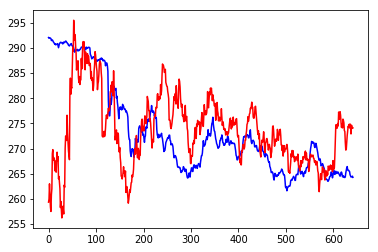

In [22]:
plt.figure()
plt.plot(list(range(len(pred))), pred, color='b')           # blue line represents the predicted values
plt.plot(list(range(len(pred))), data_test, color='r')     # red line represents the real values
plt.show()

#### 2.6.6 Evaluate the model
We use Average Error to represent the accuracy of the model. 

In [23]:
acc = []

for i in range(len(pred)):
    acc.append(np.abs((pred[i] - data_test[i]) / data_test[i]))
acc = np.average(acc)
print(acc)

0.025414720918355484


## 3 Acknowledgement 
- I would like to thank Hangjiweilaicloud for providing tutorials about Prediction of Stock Prices Based on LSTM. 
- Website: http://aistudio.baidu.com/?_=1538223849065#/projectdetail/21919